# Postprocessing: Remove molecules with large distances!

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import math
import multiprocessing
from pathlib import Path
import pickle
import sys

import matplotlib.pyplot as plt
import pandas as pd

from kinsim_structure.auxiliary import KlifsMoleculeLoader, PdbChainLoader
from kinsim_structure.encoding import SpatialFeatures

In [4]:
pd.set_option('display.max_rows', 100)

## IO paths

In [5]:
path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'
path_to_kinsim = Path('/') / 'home' / 'dominique' / 'Documents' / 'projects' / 'kinsim_structure'
path_to_results = path_to_kinsim / 'results' / 'postprocessing'

path_to_results.mkdir(parents=True, exist_ok=True)

metadata_path = path_to_data / 'preprocessed' / 'klifs_metadata_preprocessed.csv'

## Load metadata

In [6]:
klifs_metadata = pd.read_csv(metadata_path)

In [7]:
klifs_metadata.head()

,Unnamed: 0,metadata_index,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,...,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp,code
0,0,2886,AAK1,NAK,Other,4wsq,B,A,Human,K-252A,...,in,0.777,2.125,8.6,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.95,0,14,0000000000000010000001000000000000000000000000...,HUMAN/AAK1/4wsq_chainB_altA
1,1,10043,AAK1,NAK,Other,5l4q,A,A,Human,"~{N}-[5-(4-cyanophenyl)-1~{H}-pyrrolo[2,3-b]py...",...,in,0.780,2.137,9.7,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.97,0,3,0000000000000010000000000000000000000000000000...,HUMAN/AAK1/5l4q_chainA_altA
2,2,7046,AAK1,NAK,Other,5te0,A,-,Human,methyl (3Z)-3-{[(4-{methyl[(4-methylpiperazin-...,...,in,0.776,2.120,8.8,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.90,0,12,1000101000000010000001000000000000000000000000...,HUMAN/AAK1/5te0_chainA
3,3,843,ABL1,Abl,TK,2f4j,A,-,Human,CYCLOPROPANECARBOXYLIC ACID {4-[4-(4-METHYL-PI...,...,in,0.779,2.128,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.91,0,0,0000000000000010000001000000000000000000000000...,HUMAN/ABL1/2f4j_chainA
4,4,815,ABL1,Abl,TK,2g1t,A,-,Human,-,...,out,0.825,2.154,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.80,0,0,NaN,HUMAN/ABL1/2g1t_chainA


In [8]:
klifs_metadata.shape

(3880, 24)

## Generate/load distance features

In [9]:
#!python spatial_features_stats.py

In [10]:
with open(path_to_results / 'distances_all.p', 'rb') as f:
    all_distances = pickle.load(f)

In [11]:
all_distances.shape

(325299, 11)

In [12]:
all_distances.reset_index(inplace=True)

In [13]:
all_distances.head()

,klifs_id,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket,metadata_index,kinase,pdb_id,chain,alternate_model,qualityscore,resolution
0,1,17.19,12.8,19.08,14.13,2886,AAK1,4wsq,B,A,8.6,1.95
1,2,15.09,11.64,16.48,11.69,2886,AAK1,4wsq,B,A,8.6,1.95
2,3,12.41,9.24,15.13,8.24,2886,AAK1,4wsq,B,A,8.6,1.95
3,4,11.80,10.34,13.67,7.22,2886,AAK1,4wsq,B,A,8.6,1.95
4,5,12.80,12.41,12.79,9.24,2886,AAK1,4wsq,B,A,8.6,1.95


## Distances per molecule and per reference point

In [14]:
all_distances['distance_to_front_pocket']

0         14.13
1         11.69
2          8.24
3          7.22
4          9.24
          ...  
325294     6.44
325295    10.15
325296    11.38
325297    12.92
325298     14.3
Name: distance_to_front_pocket, Length: 325299, dtype: object

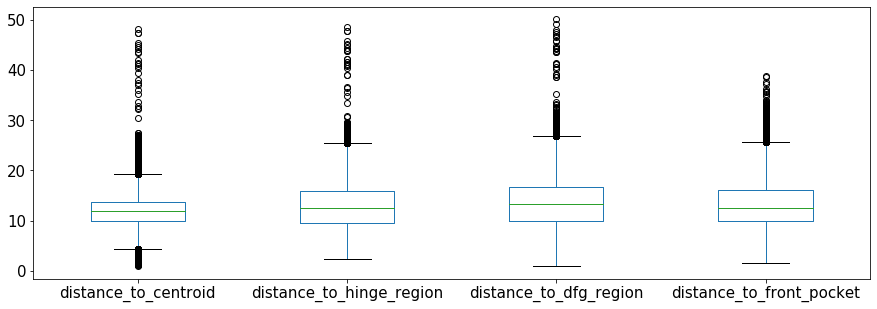

In [15]:
boxplot = all_distances[
    [
        'distance_to_centroid', 
        'distance_to_hinge_region', 
        'distance_to_dfg_region', 
        'distance_to_front_pocket'
    ]
].plot(
    kind='box',
    figsize=(15,5), 
    fontsize=15
)

In [16]:
fig = boxplot.get_figure()
fig.savefig(path_to_results / 'distances_all_boxplot.png', dpi=300)

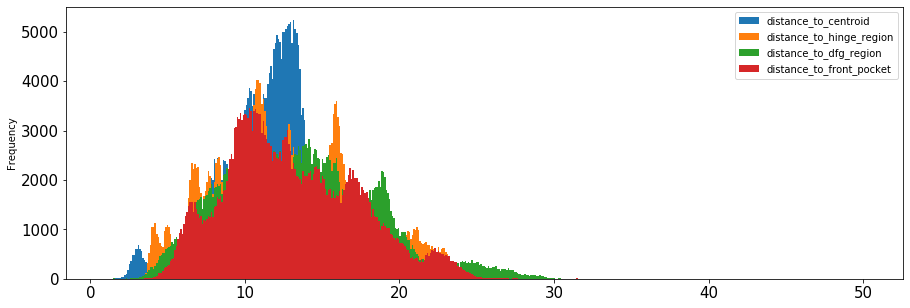

In [17]:
hist = all_distances[
    [
        'distance_to_centroid', 
        'distance_to_hinge_region', 
        'distance_to_dfg_region', 
        'distance_to_front_pocket'
    ]
].plot(kind='hist', bins=500, figsize=(15,5), fontsize=15)

## Distances vs. resolution/quality score

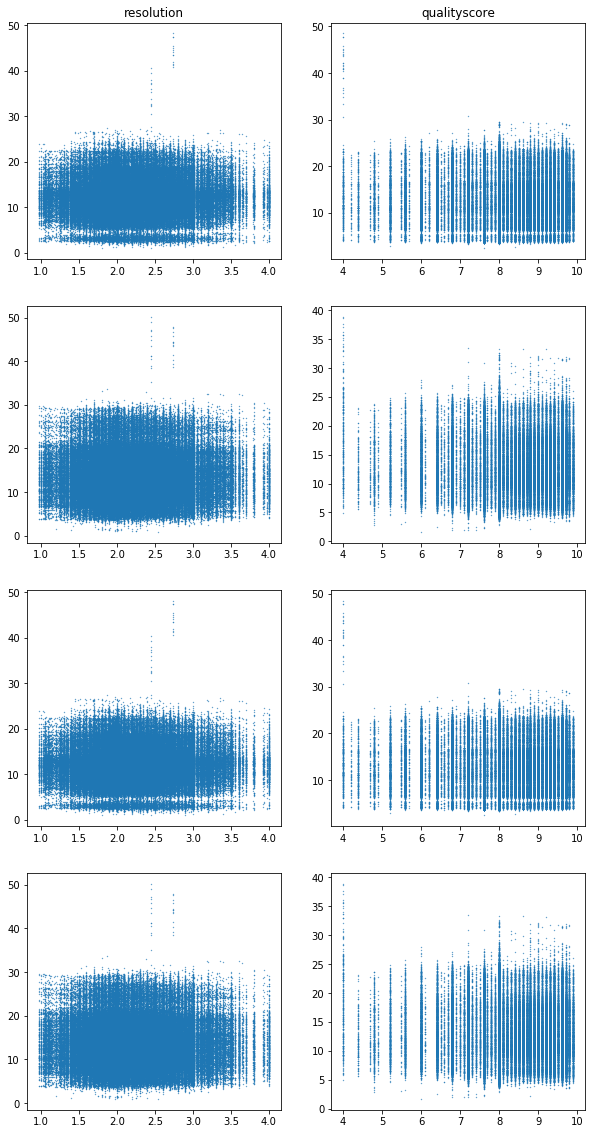

In [18]:
plt.figure(figsize=(10, 20))

x_categories = 'resolution qualityscore'.split()*4
y_categories = 'distance_to_centroid distance_to_hinge_region distance_to_dfg_region distance_to_front_pocket'.split()*2

for index, (x, y) in enumerate(zip(x_categories, y_categories)):

    plt.subplot(4, 2, index+1)
    plt.scatter(
        x=all_distances[x], 
        y=all_distances[y],
        s=0.1
    )
    if index in [0,1]:
        plt.title(x)
        
plt.savefig(path_to_results / 'distances_vs_resolution-qualityscore.png', dpi=300, bbox_inches='tight')

## Number of structures with at least one distance above a cutoff

### Large distances

In [19]:
def residues_above_distance(data, cutoff):
    """
    Get all data with distances greater than a certain distance cutoff.
    """
    
    subset = data[
        (all_distances.distance_to_hinge_region > cutoff) |
        (all_distances.distance_to_dfg_region > cutoff) |
        (all_distances.distance_to_front_pocket > cutoff) |
        (all_distances.distance_to_centroid > cutoff)
    ]
    
    return subset

In [20]:
x = []
y = []
for i in range(0, 60):
    x.append(i)
    tmp = len(residues_above_distance(all_distances, i).groupby(by='metadata_index').groups)
    y.append(tmp)

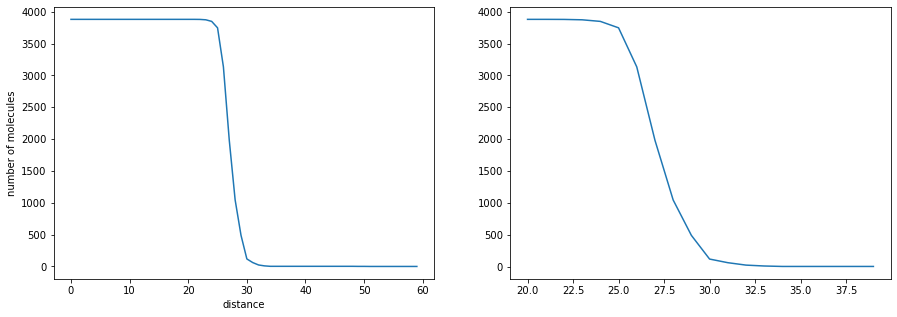

In [21]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(x,y)
plt.xlabel('distance')
plt.ylabel('number of molecules')

plt.subplot(122)
plt.plot(x[20:40],y[20:40])


### Small distances

In [22]:
def residues_below_distance(data, cutoff):
    """
    Get all data with distances greater than a certain distance cutoff.
    """
    
    subset = data[
        (all_distances.distance_to_hinge_region < cutoff) |
        (all_distances.distance_to_dfg_region < cutoff) |
        (all_distances.distance_to_front_pocket < cutoff) |
        (all_distances.distance_to_centroid < cutoff)
    ]
    
    return subset

In [23]:
x = []
y = []
for i in range(0, 60):
    x.append(i)
    tmp = len(residues_below_distance(all_distances, i).groupby(by='metadata_index').groups)
    y.append(tmp)

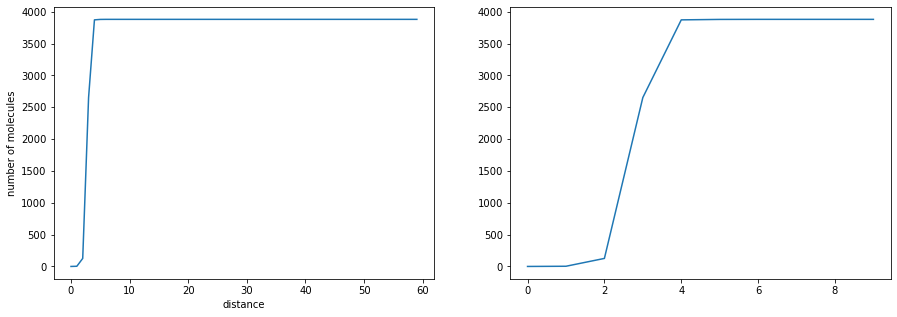

In [24]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(x,y)
plt.xlabel('distance')
plt.ylabel('number of molecules')

plt.subplot(122)
plt.plot(x[:10],y[:10])

### Focus only on large distances

In [25]:
cutoff = 35

In [26]:
bad_distances = residues_above_distance(all_distances, 35)

bad_residues = bad_distances
bad_molecules = bad_distances.groupby(by='metadata_index').first()

print(f'Number of residues with distance greater than {cutoff}: {len(bad_residues)}')
print(f'Number of molecules with distance greater than {cutoff}: {len(bad_molecules)}')

Number of residues with distance greater than 35: 27
Number of molecules with distance greater than 35: 2


In [27]:
bad_distances.groupby(by='metadata_index').groups

{11: Int64Index([182462, 182463, 182464, 182465, 182466, 182467, 182468, 182469,
             182470, 182471, 182472, 182473, 182474],
            dtype='int64'),
 6942: Int64Index([235627, 235628, 235629, 235630, 235631, 235632, 235633, 235634,
             235635, 235636, 235637, 235638, 235639, 235688],
            dtype='int64')}

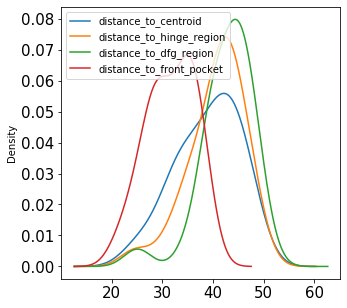

In [28]:
p = bad_distances[
    [
        'distance_to_centroid', 
        'distance_to_hinge_region', 
        'distance_to_dfg_region', 
        'distance_to_front_pocket'
    ]
].plot(kind='density', figsize=(5,5), fontsize=15)

## Write all discarded molecules to PyMol script

In [29]:
bad_molecules

,klifs_id,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket,kinase,pdb_id,chain,alternate_model,qualityscore,resolution
metadata_index,,,,,,,,,,,
11,1,32.18,34.87,38.92,26.48,ITK,4qd6,A,A,4.0,2.45
6942,1,45.37,45.82,45.77,35.65,PBK,5j0a,A,-,4.0,2.74


In [31]:
pdb_id = []
chain_id = []
alt_id = []
kinase = []

for index, row in bad_molecules.iterrows():
    
    metadata_row = klifs_metadata[klifs_metadata['metadata_index'] == index]
    
    pdb_id.append(metadata_row['pdb_id'].values[0])
    chain_id.append(metadata_row.chain.values[0])
    alt_id.append(metadata_row.alternate_model.values[0])
    kinase.append(metadata_row.kinase.values[0])

bad_molecules['pdb_id'] = pdb_id
bad_molecules['chain'] = chain_id
bad_molecules['alternate_model'] = alt_id
bad_molecules['kinase'] = kinase

In [33]:
lines = [f'from pymol import *', f'import os', f'from pymol.cgo import *\n']

for index, row in bad_molecules.iterrows():
    
    kinase = row.kinase
    pdb_id = row.pdb_id
    chain = ''
    alternate_model = ''
    
    if row.alternate_model is not '-':
        alternate_model = f'_alt{row.alternate_model}'
        
    if row.chain is not '-':
        chain = f'_chain{row.chain}'
        
    lines.append(
        f'cmd.load("{path_to_data}/raw/KLIFS_download/HUMAN/{kinase}/{pdb_id}{alternate_model}{chain}/protein.mol2", "{pdb_id}{alternate_model}{chain}")'
    )
    
    
with open(path_to_results / 'pymol_large_distances.py', 'w') as f:
    f.write('\n'.join(lines)) 

## Get filtered distances

In [34]:
all_distances.shape

(325299, 12)

In [35]:
selected_distances = all_distances[~all_distances.metadata_index.isin(bad_molecules.index)]

In [36]:
selected_distances.shape

(325129, 12)

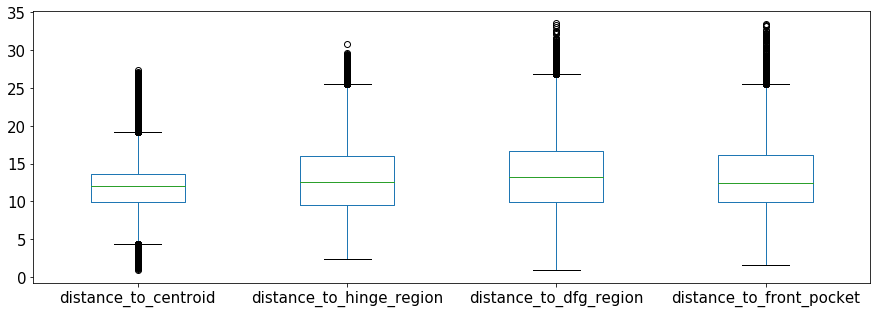

In [37]:
boxplot = selected_distances[
    [
        'distance_to_centroid', 
        'distance_to_hinge_region', 
        'distance_to_dfg_region', 
        'distance_to_front_pocket'
    ]
].plot(
    kind='box',
    figsize=(15,5), 
    fontsize=15
)

In [38]:
fig = boxplot.get_figure()
fig.savefig(path_to_results / 'distances_selected_boxplot.png', dpi=300)

## Remove molecules from metadata

In [39]:
bad_distances.groupby(by='metadata_index').first()

,klifs_id,distance_to_centroid,distance_to_hinge_region,distance_to_dfg_region,distance_to_front_pocket,kinase,pdb_id,chain,alternate_model,qualityscore,resolution
metadata_index,,,,,,,,,,,
11,1,32.18,34.87,38.92,26.48,ITK,4qd6,A,A,4.0,2.45
6942,1,45.37,45.82,45.77,35.65,PBK,5j0a,A,-,4.0,2.74


In [42]:
klifs_metadata_filtered = klifs_metadata[~klifs_metadata['metadata_index'].isin(bad_distances.metadata_index.unique())]

In [43]:
klifs_metadata_filtered.shape

(3878, 24)

In [44]:
(path_to_data / 'postprocessed').mkdir(parents=True, exist_ok=True)
klifs_metadata_filtered.to_csv(path_to_data / 'postprocessed' / 'klifs_metadata_postprocessed.csv')

## APPENDIX: Parallel coordinates: Resolution vs. distances

In [45]:
# Remove missing rows with missing values
print(f'{len(all_distances)}: Dataset')

all_distances.dropna(inplace=True)
print(f'{len(all_distances)}: Dataset without missing values')

# Round resolution and quality score
all_distances['resolution_bins'] = all_distances.resolution.apply(math.ceil)
all_distances['qualityscore_bins'] = all_distances.qualityscore.apply(math.ceil)

# Set interval of resolution and quality score
all_distances['resolution_bins'] = all_distances.resolution_bins.apply(lambda x: f'({x-1}, {x}]')
all_distances['qualityscore_bins'] = all_distances.qualityscore_bins.apply(lambda x: f'({x-1}, {x}]')

325299: Dataset
314328: Dataset without missing values


In [46]:
def plot_parallel_coordinates_distances(data):
    
    plt.figure(figsize=(15, 5))
    
    print(f'Number of structures: {data.shape[0]}')

    pd.plotting.parallel_coordinates(
        data.dropna().sort_values(by='resolution_bins', ascending=False)[
            [
                'resolution_bins',
                'qualityscore',
                'distance_to_centroid', 
                'distance_to_hinge_region', 
                'distance_to_dfg_region', 
                'distance_to_front_pocket'
            ]
        ],
        'resolution_bins',
        colormap='viridis'
    )

    plt.show()

Number of structures: 509


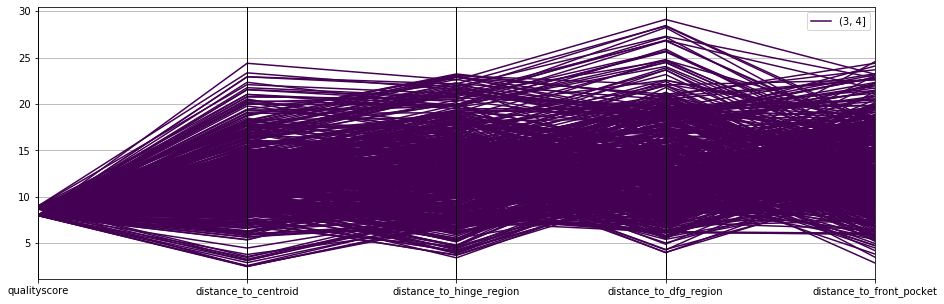

In [47]:
data = all_distances[all_distances.resolution >= 4]
plot_parallel_coordinates_distances(data)

Number of structures: 2000


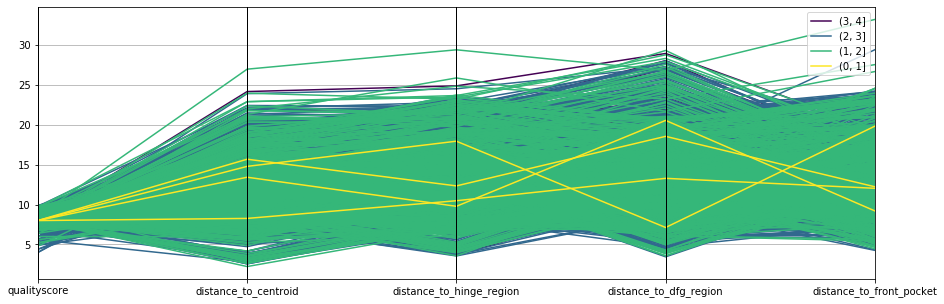

In [48]:
data = all_distances[all_distances.resolution <= 4].sample(2000)
plot_parallel_coordinates_distances(data)